[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/TomGeorge1234/RatInABox/blob/1.x/demos/reinforcement_learning_example.ipynb)

# Case study: Reinforcement Learning
### We use RatInABox to train a model-free RL agent to find a reward hidden behind a wall.

 <img src="../.images/demos/rl_agent.gif" width="300" align="center"> 

## Policy Evaluation

There are two key components to most model-free RL algorithms. Policy *evaluation* evaluates a policy to learn its "value function". Policy *improvement* uses this value function to design a better policy. Iterating between these two often results in convergence towards a near-optimal policy. 

To help with these process we define a `ValueNeuron` class. The `ValueNeuron`, which is a subclass of `FeedForwardLayer` (which is a subclass of `Neurons`) recieves feedforward input from a set of input features (these will be `PlaceCells` scattered across the `Environment`) $\{\mathsf{\phi}_{i}\}_{i=1}^{N}$. The firing rate of the `ValueNeuron` is given as a function (here, linear) of the input features:

$$ \mathsf{\hat{V}}(t;\mathsf{w}) = \Phi \big( \sum_{i=1}^{N}\mathsf{w}_{i}\mathsf{\phi}_{i}(t) \big).$$

The goal is to adjust the weights, $\mathsf{w}_{i}$, such that $\mathsf{\hat{V}}(t)$ approximates the "value" of the current policy. The value of the current policy $\pi$ is defined as the decaying sum of expected future rewards

$$\mathsf{\hat{V}}(t) \approx \mathsf{V}^{\pi}(t) = \mathbb{E} \bigg[  \int_{t}^{\infty} e^{-\frac{t^{\prime}-t}{\tau}} \mathsf{R}(t^{\prime}) dt^{\prime}\bigg] $$

where  the expectation is taken over any stochasticity present in the current policy (i.e. how the `Agent` moves) and `Environement` (although in this case the environment will be deterministic). This definition of value is temporally continuous: the key differences, compared to the more common form where value is written as a sum of rewards over discrete future timesteps, is that it is now a continuous integral over a reward *density* function and temporal discounting is done by the exponential decaying over a time period $\tau$. 

We can take the temporal derivative of this and derive a consistency equation (analagous to the Bellman equation) satisfied by this value function. This naturally gives a temporal difference-style update rule which relies on "bootstrapping" (the current estimate of the value function is used in lieu of the true value function) to optimize the weights of the value function approximation. A good reference for continuous RL is Doya (2000) if you want to know more about deriving this learning rule.

$$ \delta \mathsf{w_i}(t) = \eta \bigg( \mathsf{R}(t) +  \frac{d\mathsf{\hat{V}}(t)}{dt} - \frac{\mathsf{\hat{V}(t)}}{\tau} \bigg) \mathsf{e}_i(t) $$

For now it suffices to observe that this learning rule is very similar to the temporally discrete TD-update rule. The first term represents the continuous analog of the temporal difference error (in fact, if you rediscretise with using the euler formula $\dot{\mathsf{V}}(t) = \frac{\mathsf{V}(t+dt) - \mathsf{V}(t)}{dt}$ to replace the derivative, and set $dt =$ 1, you will see they are identical). The second term is the `eligibility trace' (using an eligibility trace is optional, and it could just be replaced with $\mathsf{\phi}_i(t)$, however doing so aids stability of the learning) of feature inputs, defined as: 

$$\mathsf{e}_i(t) = \frac{1}{\tau_{\mathsf{e}}} \int_{-\infty}^{t} e^{-\frac{t-t^{\prime}}{\tau_{\mathsf{e}}}} \mathsf{\phi}_i(t^{\prime}) dt^{\prime}$$

To learn the value function, therefore, the `ValueNeuron` needs to
1. Be able to linearly summate its inputs. Already implemented by `FeedForwardLayer.update()`
2. Store and update the eligibility trace.
3. Implement the learning rule. This will require access to the reward density function $\mathsf{R}(t)$, the eligibiilty traces $\mathsf{e}_i(t)$, the firing rate $\mathsf{\hat{V}}(t)$ and the temporal derivitive of the firing rate $\frac{d\mathsf{\hat{V}}(t)}{dt}$

We will use a temporal discounting timescale of $\tau =$ 10 seconds and an eligibility trace timescale of $\tau_{\mathsf{e}} =$ 5 seconds. The input features and rewards will both be provided by layers of `RatInABox` "`PlaceCells`". 

This figure gives a summary of the network structure and the policy improvement procedure. 

 <img src="../.images/demos/rl_networksummary.png" width="750" align="center"> 


## Install RatInABox

In [1]:
!pip install ratinabox

## Import RatInABox
..along with the `ValueNeuron` class

In [2]:
import numpy as np
from tqdm import tqdm
from time import time
from copy import copy


import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
ratinabox.stylize_plots(); ratinabox.autosave_plots=True; ratinabox.figure_directory = "../figures/"

from ratinabox.contribs.ValueNeuron import ValueNeuron

%load_ext autoreload
%autoreload 2

## Make the Environment, Agent and Neuron populations 
We now initialise an `Environment` with a wall. We put an `Agent` inside the environment. 400 `PlaceCells` of random size uniformly distributed across the environment are the input features. A single `PlaceCell` hidden behind the wall is the reward and a `ValueNeuron` (discussed above) will learn the value function by TD learning as the agent explores. 

(<Figure size 300x300 with 2 Axes>, array([<Axes: >], dtype=object))

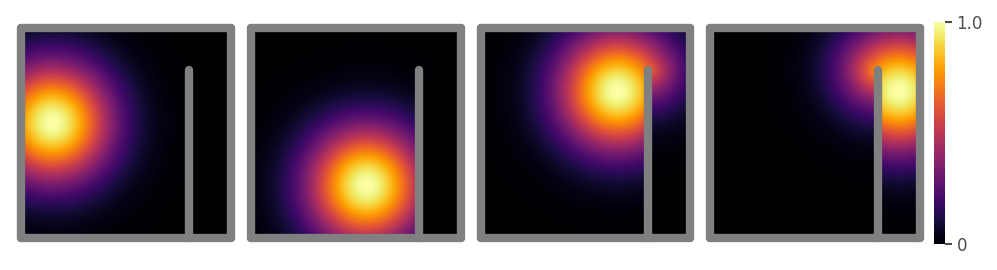

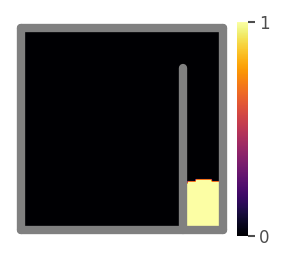

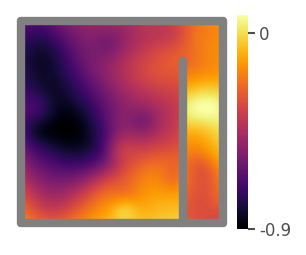

In [3]:
# Make the environment
Env = Environment()
Env.add_wall([[0.8, 0.0], [0.8, 0.8]])


# Make the agent 
Ag = Agent(Env)
Ag.dt = 50e-3  # set discretisation time, large is fine
Ag.episode_data = {
    "start_time": [],
    "end_time": [],
    "start_pos": [],
    "end_pos": [],
    "success_or_failure": [],
}  # a dictionary we will use later
Ag.exploit_explore_ratio = 0.3  # exploit/explore parameter we will use later


#Input features (400 place cells of random widths)
n_pc = 400 
Inputs = PlaceCells(
    Ag,
    params={
        "n": n_pc,
        "widths": np.random.uniform(0.04, 0.4, size=(n_pc)), #large and small widths
        "color": "C1",
    },
)
# just manually setting the last four cell's widths and locations for some plots I wish to make later, this is not critical
Inputs.place_cell_widths[-4:] = 0.2
Inputs.place_cell_centres[-4:] = np.array(
    [[0.15, 0.55], [0.55, 0.25], [0.65, 0.7], [0.9, 0.7]]
)
Inputs.plot_rate_map(chosen_neurons=[-4, -3, -2, -1])


#The reward neuron (another place cell hidden behind the barrier) 
Reward = PlaceCells(
    Ag,
    params={
        "n": 1,
        "place_cell_centres": np.array([[0.9, 0.05]]),
        "description": "top_hat",
        "widths": 0.2,
        "max_fr": 1,
        "color": "C5",
    },
)
Reward.episode_end_time = 3  # a param we will use later
Reward.plot_rate_map(chosen_neurons="1")


# The Value Neuron
# Now initialise a Value neuron, full documentation of this class in ratinabox/contribs/ValueNeuron.py
# It's a feedforward layer summing (then non-linearly activating) its input features. 
# It takes: 
# • a list of inputs (the place cells we just made) 
# • a timescale for the discounting of future rewards (tau)
# • a non-linear activation function (relu)
ValNeur = ValueNeuron(
    Ag, params={"input_layer": Inputs, 
                "tau": 10,
                "eta":0.001,
                "L2": 0.1,  # L2 regularisation
                "activation_params": {"activation": "linear"}, #can try with relu, tanh, softmax etc. see ratinabox/utils.py: activate() for list
                "color": "C2"}
)
ValNeur.max_value = np.max(ValNeur.get_state(evaluate_at='all')) #to be periodically updated, a scale for how "big" the vf is so we know where the threshold
ValNeur.plot_rate_map(chosen_neurons="1")

## Policy Improvement
Now we have a neuron capable of learning the value function under its current policy ("policy evaluation") the next job is to use this to improve the policy ("policy improvement") towards an optimal one. 

To do this will use the current estimate of value function to set a "drift" velocity which is along the direction of steepest ascent of the value function. The agents motion model will be biased accelerate it towards this drift velocity. This way the `Agent` is encouraged to move towards regions of higher and higher value. The drift velocity will be in the direction of steep ascent of the `ValueNeuron` rate map. This method of value ascent is close to a continuous analog of a "greedy policy optimization" in continuous action space. 

In [4]:
# a function which takes a value neuron and a position and returns the direction of steepest ascent of the value function at that position
def get_steep_ascent(ValueNeuron, pos):
    """This function will be used for policy improvement. Calculates direction steepest ascent (gradient) of the value function and returns a drift velocity in this direction. Returns None when the local gradient is exceedingly low"""
    V = ValueNeuron.get_state(evaluate_at=None, pos=pos)[0][0] #query the firing rate at the given position
    if V <= 0.05*ValueNeuron.max_value:
        return None # if the value function is too low it is unreliable, return None
    else:  # calculate gradient locally
        V_plusdx = ValueNeuron.get_state(evaluate_at=None, pos=pos + np.array([1e-3, 0]))[0][0]
        V_plusdy = ValueNeuron.get_state(evaluate_at=None, pos=pos + np.array([0, 1e-3]))[0][0]
        gradV = np.array([V_plusdx - V, V_plusdy - V])
        norm = np.linalg.norm(gradV)
        gradV = gradV / norm
        return gradV

Learing proceeds in episodes. Each episode ends when the agent gets close to the reward or times out (60 seconds). Initially the drift velocity is very weak relative to the random policy (controlled using the `drift_to_random_strength_ratio` argument) but this gets stronger as more successful episodes occur and the agent should (hopefully) converge on an optimal policy. Each episode ends probabilistically according to the firing rate of the reward neurons (when you are close to the reward it is likely to terminate soon) 

Every 10 episodes we "cache" a copy of the `ValueNeuron` and use this, for the next batch of 10 episodes to provide the steepest ascent direction. This technique of only periodically updating a reference value function during learning is known to improve stability in RL. We'll store details (start/end time and positions of each episode) in the `Agent` class. 

In [5]:
def do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=True, max_t=60):
    """
    Runs an "episode" of the agent moving around the environment. The agents policy is guided by the value function of the ref_ValNeur (approximately equivalent the epislon greedy). Meanwhile the value function of valNeur is being trained on the (greedy) policy.
    
    ref_ValNeur: the fixed reference value function used for getting the drift velocity
    ValNeur: the value function being trained
    Ag: the agent
    Inputs: the input features
    Reward: the reward neuron
    train: whether to train the value function or not
    max_t: the maximum time the episode can run for before timeout"""
    
    #save start time and position
    Ag.episode_data["start_time"].append(Ag.t)
    Ag.episode_data["start_pos"].append(Ag.pos)

    #resets to zero the eligibility trace and the td error ready for a new episode 
    ValNeur.reset() 

    while True:
        #get greedy direction of steepest ascent of the value function
        gradV = get_steep_ascent(ref_ValNeur, Ag.pos)
        if gradV is None: drift_velocity = None #if None, the agent will just randomly explore
        else: drift_velocity = 3 * Ag.speed_mean * gradV
        # you can ignore this (force agent to travel towards reward when v nearby) helps stability.
        if (Ag.pos[0] > 0.8) and (Ag.pos[1] < 0.4):
            dir_to_reward = Reward.place_cell_centres[0] - Ag.pos
            drift_velocity = (
                3 * Ag.speed_mean * (dir_to_reward / np.linalg.norm(dir_to_reward))
            )

        # move the agent
        Ag.update(
            drift_velocity=drift_velocity,
            drift_to_random_strength_ratio=Ag.exploit_explore_ratio,
        )
        # update inputs and train weights
        Inputs.update()
        Reward.update()
        ValNeur.update()
        # train the weights
        if train == True:
            ValNeur.update_weights(reward = Reward.firingrate)
        # end episode when at some random moment when reward is high OR after timeout
        if np.random.uniform() < Ag.dt * Reward.firingrate / Reward.episode_end_time:
            Ag.exploit_explore_ratio *= 1.1  # policy gets greedier if it was successful
            Ag.episode_data["success_or_failure"].append(1)
            break
        if (Ag.t - Ag.episode_data["start_time"][-1]) > max_t:  # timeout
            Ag.episode_data["success_or_failure"].append(0)
            break
    Ag.episode_data["end_time"].append(Ag.t)
    Ag.episode_data["end_pos"].append(Ag.pos)
    Ag.exploit_explore_ratio = max(0.1, min(1, Ag.exploit_explore_ratio)) #keep between 0.1 and 1
    Ag.velocity = np.random.uniform(-0.1, 0.1, size=(2,))
    return

In this episode (where training is turned off but `Agent.exploit_explore_ratio` is high) you may see how following a drift velocity proportional to the gradient of the value function causes the agent to "ascend" the value function

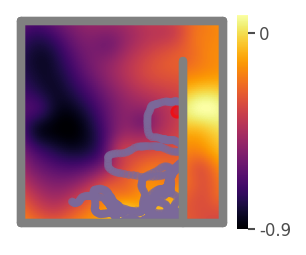

In [6]:
Ag.exploit_explore_ratio = 1 # set this high so agent climbs the VF
do_episode(ValNeur=ValNeur, ref_ValNeur=ValNeur, Ag=Ag, Inputs=Inputs, Reward=Reward, train=False, max_t=60)
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0])

## Training: Let the Agent explore and learn
Now we will do a test over 10 batches of 10 episodes each

Batch 1/10: 8 timeouts, 2 successes, average episode time 54.57s
Batch 2/10: 7 timeouts, 3 successes, average episode time 47.57s
Batch 3/10: 9 timeouts, 1 successes, average episode time 54.16s
Batch 4/10: 9 timeouts, 1 successes, average episode time 54.16s
Batch 5/10: 10 timeouts, 0 successes, average episode time 60.00s
Batch 6/10: 5 timeouts, 5 successes, average episode time 44.86s
Batch 7/10: 1 timeouts, 9 successes, average episode time 24.84s
Batch 8/10: 0 timeouts, 10 successes, average episode time 11.69s
Batch 9/10: 0 timeouts, 10 successes, average episode time 11.53s
Batch 10/10: 0 timeouts, 10 successes, average episode time 11.02s


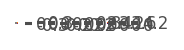

In [7]:
Ag.exploit_explore_ratio = (
    0.2  # mostly random exploration to start, this will increase with time
)

batches = 10
episodes_per_batch = 10

for i in range(batches):
    # cache copy of the ValueNeuron and use this to dictate policy
    ref_ValNeur = copy(ValNeur)
    ref_ValNeur.max_value = np.max(ref_ValNeur.get_state(evaluate_at="all"))
    # ref_ValNeur.max_fr = np.max(ValNeur.get_state(evaluate_at="all"))

    for j in range(episodes_per_batch):  # batches of episodes
        Ag.pos = Env.sample_positions(n=1)[0]  # put agent in random position
        do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=True)
        

    n_success = sum(Ag.episode_data["success_or_failure"][-episodes_per_batch:])
    av_episode_time = np.mean(
        np.array(Ag.episode_data["end_time"][-episodes_per_batch:])
        - np.array(Ag.episode_data["start_time"][-episodes_per_batch:])
    )
    print(
        f"Batch {i+1}/{episodes_per_batch}: {episodes_per_batch-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s"
    )


Plot the trajectory coloured by time, you should see how trajectories learn to find the reward behind the wall

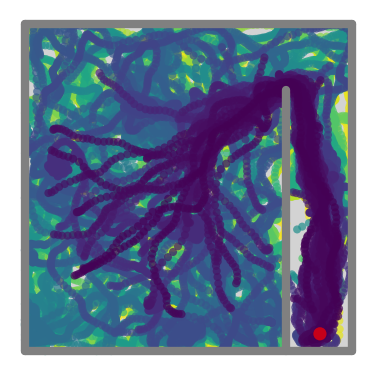

In [8]:
fig, ax = Ag.plot_trajectory(t_start=Ag.episode_data['start_time'][0], 
                             t_end  =Ag.episode_data['end_time'][-1],
                             color='changing')

Plot the (now optimal) value function

(<Figure size 300x300 with 2 Axes>, array([<Axes: >], dtype=object))

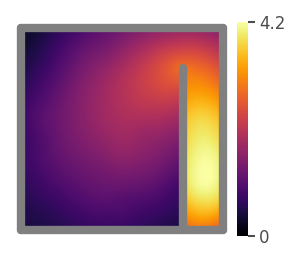

In [9]:
ValNeur.plot_rate_map()

Lets make a pretty figure. We'll start the agent off at 8 evenly spaced locations across the environment and run an apisode from each point.

Batch 10/10: 0 timeouts, 8 successes, average episode time 11.23s


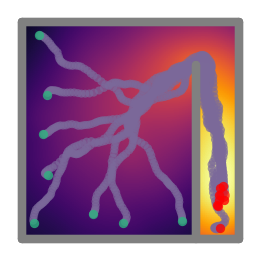

In [12]:
test_pos = np.array(
    [
        [0.1, 0.9],
        [0.1, 0.7],
        [0.1, 0.5],
        [0.1, 0.3],
        [0.1, 0.1],
        [0.3, 0.1],
        [0.5, 0.1],
        [0.7, 0.1],
    ]
)
test_pos += np.random.uniform(-0.05, 0.05, size=test_pos.shape)
np.random.shuffle(test_pos)
Env.walls[-1, -1, -1] = 0.8
Reward.episode_end_time = 1
for j in range(8):
    Ag.pos = test_pos[j]
    do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=False)
n_success = sum(Ag.episode_data["success_or_failure"][-8:])
av_episode_time = np.mean(
    np.array(Ag.episode_data["end_time"][-8:])
    - np.array(Ag.episode_data["start_time"][-8:])
)
print(
    f"Batch {i+1}/{10}: {8-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s"
)

Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map(colorbar=False)
fig, ax = Ag.plot_trajectory(
    fig=fig, ax=ax[0], t_start=Ag.episode_data["start_time"][-8] + Ag.dt
)
start_pos = np.array(Ag.episode_data["start_pos"][-8:])
end_pos = np.array(Ag.episode_data["end_pos"][-8:])
ax.scatter(
    start_pos[:, 0], start_pos[:, 1], s=20, c="C2", zorder=11, alpha=0.8, linewidths=0
)
ax.scatter(
    end_pos[-8:, 0], end_pos[-8:, 1], s=20, c="r", zorder=11, alpha=0.8, linewidths=0
)

## A freebie from doing RL in continuous space and time

One of the key premises leading to the development of `RatInABox` is that, oftentimes, studying systems in their full form -- i.e. using motion models which are continuous in time and state encodings which are continuous in space and interact adaptively with the environment -- can lead to results which are quantitatively different from gridworld models. These might explain aspects of behaviour inaccessible using discretised models. What might these be? 

As an example, suppose a shortcut was made avaiable near the bottom of the wall. In this case the place cells near the reward location might be expected to 'bleed' out. This occurs naturally in `RatInABox`: since `PlaceCell` firing rates are calculated on-the-fly (not cached) any change to the environment immediately effects the place cells. Since the `ValueNeuron` receptive field is just a linear sum of these place cells as the place cells bleed out through the hole in the wall the inferred value of this area increases. The policy (gradient ascent of the value function) may then follow this and automatically find a `shortcut' to the reward with zero extra training. Let's find out: 

Here we make a shortcut available by manually altering the wall structure of the environment. Everythign else is taken care of by the software (i.e. input `PlaceCell` firing fields, and the `ValueNeuron` firing will all automatically respect this new change in the environment). *No extra training is performed*

In [19]:
# WITHOUT SHORTCUT
Env.walls[-1] = np.array([[0.8, 0.0], [0.8, 0.8]])
Reward.episode_end_time = 3
Ag.pos = np.array([0.4, 0.2])
do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=False)

# plot...
Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map()
Ag.plot_trajectory(
    fig=fig, ax=ax[0], t_start=Ag.episode_data["start_time"][-1] + Ag.dt
)

# ...or animate 
anim1 = Ag.animate_trajectory(
    t_start=Ag.episode_data["start_time"][-1] + Ag.dt,
    t_end=Ag.history["t"][-1],
    speed_up=5,
)

In [20]:
anim1 #show it 

In [24]:
# WITH SHORTCUT
Env.walls[-1] = np.array([[0.8, 0.1], [0.8, 0.8]])
Reward.episode_end_time = 3
Ag.pos = np.array([0.4, 0.2])
do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=False)
Ag.average_measured_speed = 0.15

# plot...
fig1, ax1 = ValNeur.plot_rate_map()
Ag.plot_trajectory(
    fig=fig1, ax=ax1[0], t_start=Ag.episode_data["start_time"][-1] + Ag.dt
)

# ...or animate 
anim2 = Ag.animate_trajectory(
    t_start=Ag.episode_data["start_time"][-1] + Ag.dt,
    t_end=Ag.history["t"][-1],
    speed_up=1,
)



In [25]:
anim2 # show it 

In [26]:
Env.walls[-1] = np.array([[0.8, 0.0], [0.8, 0.8]]) #put the wall back where it was 

## Make some animations to explain this project
Here I'm just running the simulation again starting from two positions and making some nice animations (of the neurons rates and trajcetories) and plots (of the neurons rate maps). This may not be of interest to you, nothing is particularly new here. It takes a while because animations are expensive to make.

In [27]:
test_pos = np.array([[0.1, 0.5], [0.75, 0.05], [0.1, 0.95]])
n_test = len(test_pos)

Reward.episode_end_time = 1
t_start = Ag.t
for j in range(n_test):
    Ag.pos = test_pos[j]
    do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=False)
t_end = Ag.t

In [28]:
# make plot of value function, place cells and reward neuron
fig, ax = ValNeur.plot_rate_map()
fig, ax = Inputs.plot_rate_map(chosen_neurons=[-4, -3, -2, -1])
fig, ax = Reward.plot_rate_map()
# make animations
anim = Ag.animate_trajectory(
    t_start=Ag.episode_data["start_time"][-n_test] + Ag.dt, fps=15
)
anim = Inputs.animate_rate_timeseries(
    t_start=Ag.episode_data["start_time"][-n_test] + Ag.dt,
    chosen_neurons=[-4, -3, -2, -1],
    fps=15,
)
anim = Reward.animate_rate_timeseries(
    t_start=Ag.episode_data["start_time"][-n_test] + Ag.dt, norm_by=1.0, fps=15
)
norm = 1.2 * max(
    ValNeur.history["firingrate"][
        np.argmin(
            np.abs(
                np.array(Ag.history["t"]) - Ag.episode_data["start_time"][-n_test]
            )
        )
    ]
)
anim = ValNeur.animate_rate_timeseries(
    t_start=Ag.episode_data["start_time"][-n_test] + Ag.dt, fps=15, norm_by=norm
)

Once tied together using third party software (here, powerpoint) the animation looks like this

<img src="../.images/demos/riab_for_rl_full.gif" width="1000" align="center"> 


## Disclaimer: 
Please note this script is intended as a tutorial, here only to demonstrate of how `RatInABox` could be used for a reinforcement learning project in continuous time and space and not, in any way, as a scientific result regarding the role of hippocampus' role in navigational reinforcement learning. 